<a href="https://colab.research.google.com/github/rafik-chemli/NRCan-Statcan-Furnace-CFD-Analysis/blob/main/NRCan_Statcan_Furnace_CFD_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## PreProcessing
We read a specific file given in CSV format file_3.1bar_491.5kgm3_0.064VM.csv and determine the state of particles based on the C++ Code provided by subject matter experts:



```c
rho_L = 3440;           // density of the bottom liquid
gamma = 0.568;          // surface tension of the bottom liquid
vel[0] = TP_VEL(tp)[0]; // velocity components of a particle
vel[1] = TP_VEL(tp)[1];
vel[2] = TP_VEL(tp)[2];
We = rho_L * SQR(vel[1]) * TP_DIAM(tp) / gamma; // dimensionless parameter - Weber
Bo = rho_L * 9.81 * SQR(TP_DIAM(tp)) / gamma;   // dimensionless parameter - Bond
lambda_squared = SQR(TP_RHO(tp) / rho_L);       // dimensionless parameter
WeBo = We * sqrt(Bo * Bo * Bo);                 // dimensionless parameter

if (WeBo >= 12 / lambda_squared) {
    // penetrating the surface, particle trajectory is terminated
    fate = 0;
    return PATH_END;
} else if (WeBo < 12 / lambda_squared && WeBo >= 6 / lambda_squared) {
    // bouncing, particle trajectory continues
    fate = 1;
    nor_coeff = 0.1; // changing the trajectory of the particle as it bounces
    tan_coeff = 0.1; // changing the trajectory of the particle as it bounces
} else {
    // oscillating afloat the surface, particle trajectory is terminated
    fate = 2;
    return PATH_END;
}
```

There are three possible outcomes:
0. particle penetrates the bottom surface (particle trajectory is ended once that happens)
1. particle bounces (particle trajectory continues)
2. particle oscillates/floats on the surface (particle trajectory is ended once that happens, as it can cause problems to model it further)

Although outcomes 0 and 2 lead to particle being terminated in the model, only 0. is desirable. The particle model returns the outcome as an integer (fate), which I used to build the Bayesian model surface by counting the # of particles that penetrate versus the total # of particles introduced in each injection.





In [ ]:
import pandas as pd
import numpy as np

df_path = '/content/drive/MyDrive/Colab Notebooks/statcan/furnace/CFD_particle_data/file_3.1bar_491.5kgm3_0.064VM.csv'
data = pd.read_csv(df_path)


# Constants: Density and Surface Tension of the bottom liquid
rho_L = 3440
gamma = 0.568


def calculate_we_bo_lambda(row):
    # Extract necessary values from the row using the correct column names
    particle_velocity = [row['ParticleXVelocity m/s'],
                         row['ParticleYVelocity m/s'],
                         row['ParticleZVelocity m/s']]
    particle_diameter = row['ParticleDiameter m']
    particle_density = row['ParticleDensity kg/m3']

    # Calculate the magnitude of the particle velocity
    velocity_magnitude = np.sqrt(sum(v ** 2 for v in particle_velocity))

    # Weber and Bond number calculations
    We = rho_L * (velocity_magnitude ** 2) * particle_diameter / gamma
    Bo = rho_L * 9.81 * (particle_diameter ** 2) / gamma
    lambda_squared = (particle_density / rho_L) ** 2

    return We, Bo, lambda_squared


def determine_state(row):
    We, Bo, lambda_squared = calculate_we_bo_lambda(row)
    WeBo = We * np.sqrt(Bo ** 3)

    if WeBo >= 12 / lambda_squared:
        return 0  # Penetrating the surface
    elif 6 / lambda_squared <= WeBo < 12 / lambda_squared:
        return 1  # Bouncing
    else:
        return 2  # Oscillating/afloat


# Determine state by calculating it
data['state'] = data.apply(determine_state, axis=1)

# Clean the column names by stripping leading/trailing spaces and replacing spaces with underscores
data.columns = data.columns.str.strip().str.replace(' ', '_').str.replace('.', '')

# Assuming 'data' is already defined and contains your data
pd.set_option('display.float_format', lambda x: '%.10f' % x)  # Set precision for display

df = data.copy()

# Compute the adjusted time and add it to the original time
df['AdjustedTime'] = df.groupby('ParticleID_-').apply(lambda x: x['ParticleResidenceTime_s'] + x.groupby((x['ParticleResidenceTime_s'].diff(1) > 0).cumsum()).cumcount() * 1e-11).reset_index(level=0, drop=True)

# Create tracker_id based on ParticleID and reset in time
current_particle_id = None
previous_time = None
tracker_id = 0
tracker_ids = []

for index, row in df.iterrows():
    if row['ParticleID_-'] != current_particle_id:
        current_particle_id = row['ParticleID_-']
        tracker_id += 1
        previous_time = None
    elif previous_time is not None and row['AdjustedTime'] < previous_time:
        tracker_id += 1
    tracker_ids.append(tracker_id)
    previous_time = row['AdjustedTime']

df['tracker_id'] = tracker_ids

df = df.drop(columns=['ParticleResidenceTime_s', 'UserValue0_-'])
#print(df.columns)
#print(df['tracker_id'])

## Interactive Plotting

Every individual particle within the CFD simulation is uniquely identified with a Tracker_id, distinguishing it even when several particles share the same Particle_ID.

The purpose of this interactive plotting feature is to facilitate the visualization of each particle's behavior along the y-axis over time, offering a dynamic and detailed examination of its movement patterns.


You can select a different tracker_id in the following code to visualize any particle you desire.

In [ ]:
import plotly.express as px

tracker_id = 484      # Set the tracker_id for the particle of interest
Particle_Dimension = 'y'

Particle_Dimension = Particle_Dimension.capitalize()

# Filter the dataframe for the specified tracker_id.
filtered_df = df[df['tracker_id'] == tracker_id]

# Define the color map
color_map = {0: 'red', 1: 'blue', 2: 'grey'}

# Define the state labels as strings
state_labels = {0: 'Penetrating', 1: 'Bouncing', 2: 'Oscillating'}

# Convert the 'state' to a categorical type, using the state_labels for naming categories
filtered_df['state'] = pd.Categorical(filtered_df['state'].map(state_labels), categories=state_labels.values())

# Now use the mapped 'state' for color encoding in Plotly
fig = px.scatter(filtered_df, x='AdjustedTime', y=f'Particle{Particle_Dimension}Position_m',
                 color='state', symbol='tracker_id',
                 size='ParticleDiameter_m',
                 color_discrete_map={v: color_map[k] for k, v in state_labels.items()},  # Use the updated color map
                 hover_data=['BmMassTransferNumber_-', 'ParticleDiameter_m',
                             'ParticleTemperature_K', 'ParticleDensity_kg/m3',
                             'ParticleMass_kg'],
                 labels={'state': 'State'})

# Update layout for title and axes
fig.update_layout(
    title=f'Tracker {tracker_id} - {Particle_Dimension} Position Over Time',
    xaxis_title='Adjusted Time',
    yaxis_title=f'Particle {Particle_Dimension} Position (m)',
    legend_title='State'
)

# Show the figure
fig.show()


<ipython-input-36-f44445df8584>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:


import pandas as pd
import numpy as np

df_path = '/content/drive/MyDrive/Colab Notebooks/statcan/furnace/CFD_particle_data/file_3.1bar_491.5kgm3_0.064VM.csv'
data = pd.read_csv(df_path,  )


# Constants: Density and Surface Tension of the bottom liquid
rho_L = 3440
gamma = 0.568


def calculate_we_bo_lambda(row):
    # Extract necessary values from the row using the correct column names
    particle_velocity = [row['ParticleXVelocity m/s'],
                         row['ParticleYVelocity m/s'],
                         row['ParticleZVelocity m/s']]
    particle_diameter = row['ParticleDiameter m']
    particle_density = row['ParticleDensity kg/m3']

    # Calculate the magnitude of the particle velocity
    velocity_magnitude = np.sqrt(sum(v**2 for v in particle_velocity))

    # Weber and Bond number calculations
    We = rho_L * (velocity_magnitude ** 2) * particle_diameter / gamma
    Bo = rho_L * 9.81 * (particle_diameter ** 2) / gamma
    lambda_squared = (particle_density / rho_L) ** 2

    return We, Bo, lambda_squared

def determine_state(row):
    We, Bo, lambda_squared = calculate_we_bo_lambda(row)
    WeBo = We * np.sqrt(Bo ** 3)

    if WeBo >= 12 / lambda_squared:
        return 0  # Penetrating the surface
    elif 6 / lambda_squared <= WeBo < 12 / lambda_squared:
        return 1  # Bouncing
    else:
        return 2  # Oscillating/afloat

# Determine state by calculating it
data['state'] = data.apply(determine_state, axis=1)

# Clean the column names by stripping leading/trailing spaces and replacing spaces with underscores
data.columns = data.columns.str.strip().str.replace(' ', '_').str.replace('.', '')


# Assuming 'data' is already defined and contains your data
pd.set_option('display.float_format', lambda x: '%.10f' % x)  # Set precision for display

df = data.copy()
epsilon = 1e-11  # Small enough not to affect the overall scale but enough to make timestamps unique

# Compute the adjusted time and add it to the original time
df['AdjustedTime'] = df['ParticleResidenceTime_s'] + df.groupby('ParticleResidenceTime_s').cumcount() * epsilon

df = df.drop(columns=['ParticleResidenceTime_s','UserValue0_-'])
print(df.columns)




## General Exploration of each variable over time

<ipython-input-3-388843464f3a>:63: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()  # Adjust layout to prevent label overlap
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


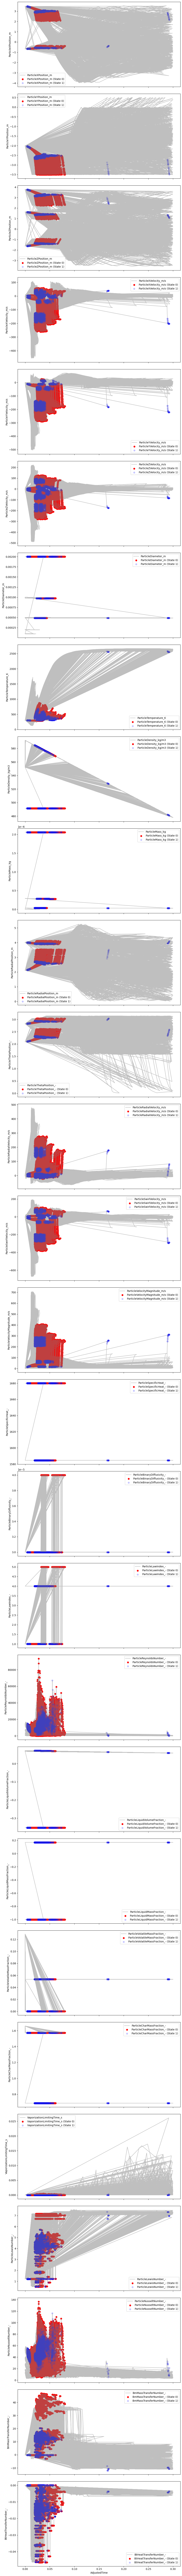

In [ ]:
# !pip install fastdtw
import matplotlib.pyplot as plt

#Adjusted Time
# Filter the DataFrame AdjustedTime
df_filtered = df[df['AdjustedTime'] < 0.30]

# Define the variables to plot.
variables_to_plot = [
    'ParticleXPosition_m',
    'ParticleYPosition_m',
    'ParticleZPosition_m',
    'ParticleXVelocity_m/s',
    'ParticleYVelocity_m/s',
    'ParticleZVelocity_m/s',
    'ParticleDiameter_m',
    'ParticleTemperature_K',
    'ParticleDensity_kg/m3',
    'ParticleMass_kg',
    'ParticleRadialPosition_m',
    'ParticleThetaPosition_-',
    'ParticleRadialVelocity_m/s',
    'ParticleSwirlVelocity_m/s',
    'ParticleVelocityMagnitude_m/s',
    'ParticleSpecificHeat_-',
    'ParticleBinaryDiffusivity_-',
    'ParticleLawIndex_-',
    'ParticleReynoldsNumber_-',
    'ParticleLiquidVolumeFraction_-',
    'ParticleLiquidMassFraction_-',
    'ParticleVolatileMassFraction_-',
    'ParticleCharMassFraction_-',
    'VaporizationLimitingTime_s',
    'ParticleLewisNumber_-',
    'ParticleNusseltNumber_-',
    'BmMassTransferNumber_-',
    'BtHeatTransferNumber_-',
]




# Determine the number of variables to plot.
n_variables = len(variables_to_plot)

# Create subplots
fig, axs = plt.subplots(n_variables, 1, figsize=(10, 5 * n_variables), sharex=True)

# Plot each variable for the filtered data.
for i, var in enumerate(variables_to_plot):
    # Plot the variable with a focus on adjusted time under 0.25 seconds.
    axs[i].plot(df_filtered['AdjustedTime'], df_filtered[var], label=var, color='grey', alpha=0.5)

    # Highlight the periods where state is '0'.
    state_zero_indices = df[df['state'] == 0].index
    state_one_indices = df[df['state'] == 1].index
    axs[i].scatter(df.loc[state_zero_indices, 'AdjustedTime'], df.loc[state_zero_indices, var], color='red', label=f"{var} (State 0)" , alpha=1.0)
    axs[i].scatter(df.loc[state_one_indices, 'AdjustedTime'], df.loc[state_one_indices, var], color='blue', label=f"{var} (State 1)" , alpha=0.2)
    axs[i].set_ylabel(var)
    axs[i].legend()

plt.xlabel('AdjustedTime')
plt.tight_layout()  # Adjust layout to prevent label overlap
plt.show()


In [ ]:


# Sorting the dataframe by 'ParticleID' and 'AdjustedTime' to ensure it's ordered.
df_sorted = df.sort_values(by=['ParticleID_-', 'AdjustedTime'])

# Grouping by 'ParticleID' and get the last entry (which is the latest in time due to sorting).
final_states = df_sorted.groupby('ParticleID_-').last()['state']

# Check which particles have their final state as '0'.
particles_ending_in_state_0 = final_states[final_states == 0].index
count_particles_ending_in_state_0 = len(particles_ending_in_state_0)

print(f"Number of particles that end in state '0' considering the AdjustedTime: {count_particles_ending_in_state_0}")


num_unique_particles = df_sorted['ParticleID_-'].nunique()
print("Number of unique particles:", num_unique_particles)



# Initialize a dictionary to count each transition type.
transition_counts = {
    "0_to_1": 0,
    "0_to_2": 0,
    "1_to_0": 0,
    "1_to_2": 0,
    "2_to_0": 0,
    "2_to_1": 0,
}

# Iterate over each particle and count the transitions.
for particle_id, group in df.groupby('ParticleID_-'):
    states = group['state'].values
    for i in range(len(states) - 1):
        current_state, next_state = states[i], states[i + 1]
        if current_state == 0 and next_state == 1:
            transition_counts["0_to_1"] += 1
        elif current_state == 0 and next_state == 2:
            transition_counts["0_to_2"] += 1
        elif current_state == 1 and next_state == 0:
            transition_counts["1_to_0"] += 1
        elif current_state == 1 and next_state == 2:
            transition_counts["1_to_2"] += 1
        elif current_state == 2 and next_state == 0:
            transition_counts["2_to_0"] += 1
        elif current_state == 2 and next_state == 1:
            transition_counts["2_to_1"] += 1

# Print out the transition counts.
for transition, count in transition_counts.items():
    print(f"Number of {transition.replace('_', ' ')} transitions: {count}")

# Initialize a dictionary to count the transitions to state '0' for each particle.
transitions_to_0_counts = {}

# Iterate over each particle and count the transitions to state '0'.
for particle_id, group in df.groupby('ParticleID_-'):
    states = group['state'].values
    # Count transitions to '0' excluding the initial state if it's '0'.
    transitions_to_0 = sum((states[i] != 0 and states[i + 1] == 0) for i in range(len(states) - 1))
    transitions_to_0_counts[particle_id] = transitions_to_0

# Now determine the number of particles with multiple transitions to '0'.
particles_with_multiple_0_transitions = sum(count > 1 for count in transitions_to_0_counts.values())

print(f"Number of particles that transition to state '0' multiple times: {particles_with_multiple_0_transitions}")

#filter ID and initial diameter.

# 5 initial diameter



Number of particles that end in state '0' considering the AdjustedTime: 0
Number of unique particles: 882
Number of 0 to 1 transitions: 301
Number of 0 to 2 transitions: 1777
Number of 1 to 0 transitions: 2949
Number of 1 to 2 transitions: 127
Number of 2 to 0 transitions: 11
Number of 2 to 1 transitions: 2775
Number of particles that transition to state '0' multiple times: 882


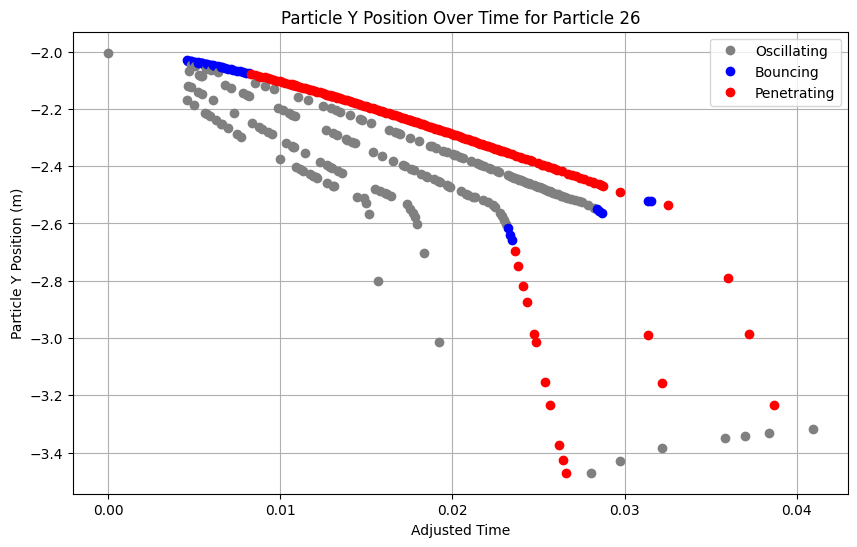

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'state' contains numerical values 0, 1, and 2. Adjust if they are not numerical.
# Map the states to colors.
color_map = {0: 'red', 1: 'blue', 2: 'grey'}
state_labels = {0: 'Penetrating', 1: 'Bouncing', 2: 'Oscillating'}

# Filter, sort, and map the dataframe for colors and labels.
filtered_sorted_df = df[df['ParticleID_-'] == 26].sort_values(by='AdjustedTime')
filtered_sorted_df['color'] = filtered_sorted_df['state'].apply(lambda x: color_map[x])

# Initialize an empty list for state and Y position without consecutive duplicates.
state_y_sequence = []

# Create a plot with the color-coded states and add legends for each state.
plt.figure(figsize=(10, 6))
for _, row in filtered_sorted_df.iterrows():
    if not state_y_sequence or row['state'] != state_y_sequence[-1][0]:
        plt.plot(row['AdjustedTime'], row['ParticleYPosition_m'], 'o', label=state_labels[row['state']] if row['state'] not in [s[0] for s in state_y_sequence] else "", color=row['color'])
        state_y_sequence.append((row['state'], row['ParticleYPosition_m']))

plt.title('Particle Y Position Over Time for Particle 26')
plt.xlabel('Adjusted Time')
plt.ylabel('Particle Y Position (m)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import plotly.express as px

particleID = 26
Particle_Dimension = 'y'


Particle_Dimension = Particle_Dimension.capitalize()
# Filter and sort the dataframe for ParticleID.
filtered_sorted_df = df[df['ParticleID_-'] == particleID].sort_values(by='AdjustedTime')

# Define the color map
color_map = {0: 'red', 1: 'blue', 2: 'grey'}

# Define the state labels (if you want to use them for the legend)
state_labels = {0: 'Penetrating', 1: 'Bouncing', 2: 'Oscillating'}

# Convert the 'state' to a categorical type, using the state_labels for naming categories
filtered_sorted_df['state'] = pd.Categorical(filtered_sorted_df['state'].map(state_labels), categories=state_labels.values())

# Now use the mapped 'state' for color encoding in Plotly
fig = px.scatter(filtered_sorted_df, x='AdjustedTime', y=f'Particle{Particle_Dimension}Position_m',
                 color='state',
                 size='ParticleDiameter_m',
                 color_discrete_map={v: color_map[k] for k, v in state_labels.items()},  # Use the updated color map
                 hover_data=['BmMassTransferNumber_-', 'ParticleDiameter_m',
                             'ParticleTemperature_K', 'ParticleDensity_kg/m3',
                             'ParticleMass_kg'],
                 labels={'state': 'State'})

# Update layout for title and axes
fig.update_layout(
    title=f'Particle {particleID} - {Particle_Dimension} Position Over Time',
    xaxis_title='Adjusted Time',
    yaxis_title=f'Particle {Particle_Dimension} Position (m)',
    legend_title='State'
)

# Show the figure
fig.show()


In [ ]:
import numpy as np

# Define a function to get and print unique diameters for a given particle ID
def print_unique_diameters(particle_id, data_frame):
    unique_diameters = data_frame[data_frame['ParticleID_-'] == particle_id]['ParticleDiameter_m'].unique()
    unique_diameters_sorted = np.sort(unique_diameters)

    formatted_diameters = [f"{diameter:.15f}" for diameter in unique_diameters_sorted]

    print(f"Formatted unique diameters for Particle {particle_id}, sorted:")
    for diameter in formatted_diameters:
        print(diameter)

# Example usage:
# Assuming df is your dataframe and has been loaded already.
print_unique_diameters(55, df)

Formatted unique diameters for Particle 55, sorted:
0.000097711400000
0.000100000000000
0.000195423000000
0.000200000000000
0.000223113000000
0.000488557000000
0.000500000000000
0.000977114000000
0.001000000000000
0.002000000000000


In [ ]:
# Group by 'ParticleID' and count unique 'Diameter' values.
diameter_counts = df.groupby('ParticleID_-')['ParticleDiameter_m'].nunique()

# Filter out the ParticleIDs that have exactly 5 different diameters.
not_five_diameters = diameter_counts[diameter_counts != 5]

# Print out the result.
print(not_five_diameters)
print(len(not_five_diameters))

ParticleID_-
0.0000000000       9
1.0000000000      10
2.0000000000       9
3.0000000000       9
4.0000000000       9
                  ..
877.0000000000     9
878.0000000000    10
879.0000000000     9
880.0000000000    10
881.0000000000    10
Name: ParticleDiameter_m, Length: 882, dtype: int64
882


In [ ]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Assuming df already contains 'ParticleXPosition_m' and 'ParticleZPosition_m' columns.
# Filter and sort the dataframe by time to maintain chronological order for the animation.
filtered_sorted_df = df[df['ParticleID_-'] == 26].sort_values(by='AdjustedTime')

# Create a list of frames, each frame corresponding to a point in time.
frames = [go.Frame(
    data=[go.Scatter3d(
        x=[row['ParticleXPosition_m']],
        y=[row['ParticleYPosition_m']],
        z=[row['ParticleZPosition_m']],
        mode='markers',
        marker=dict(size=5, color=color_map[row['state']])
    )],
    name=str(row['AdjustedTime'])
) for index, row in filtered_sorted_df.iterrows()]

# Define the layout with a slider and reduced font sizes.
layout = go.Layout(
    title=dict(text='Particle Movement Over Time', font=dict(size=18)),  # Reduced title font size
    scene=dict(
        xaxis=dict(title='Particle X Position (m)', title_font=dict(size=14)),  # Reduced axis title font size
        yaxis=dict(title='Particle Y Position (m)', title_font=dict(size=14)),
        zaxis=dict(title='Particle Z Position (m)', title_font=dict(size=14))
    ),
    updatemenus=[{
        'buttons': [
            {
                'args': [None, {'frame': {'duration': 500, 'redraw': True},
                                'fromcurrent': True, 'transition': {'duration': 300, 'easing': 'quadratic-in-out'}}],
                'label': 'Play',
                'method': 'animate'
            },
            {
                'args': [[None], {'frame': {'duration': 0, 'redraw': True},
                                  'mode': 'immediate',
                                  'transition': {'duration': 0}}],
                'label': 'Pause',
                'method': 'animate'
            }
        ],
        'direction': 'left',
        'pad': {'r': 10, 't': 87},
        'showactive': False,
        'type': 'buttons',
        'x': 0.1,
        'xanchor': 'right',
        'y': 0,
        'yanchor': 'top'
    }],
    sliders=[{
        'steps': [{'args': [[frame.name], {'frame': {'duration': 300, 'redraw': True},
                                             'mode': 'immediate',
                                             'transition': {'duration': 300}}],
                   'label': frame.name,
                   'method': 'animate'} for frame in frames],
        'transition': {'duration': 300},
        'x': 0.1,
        'y': 0,
        'currentvalue': {
            'font': {'size': 10},  # Reduced current value font size
            'prefix': 'Time: ',
            'visible': True,
            'xanchor': 'right'
        },
        'len': 0.9,
        'xanchor': 'left',
        'yanchor': 'top'
    }]
)

# Define the initial data setup.
fig = make_subplots(specs=[[{'is_3d': True}]])
fig.add_trace(go.Scatter3d(
    x=filtered_sorted_df['ParticleXPosition_m'],
    y=filtered_sorted_df['ParticleYPosition_m'],
    z=filtered_sorted_df['ParticleZPosition_m'],
    mode='markers',
    marker=dict(color=filtered_sorted_df['state'].map(lambda s: color_map[s]), size=5)
))

fig.frames = frames
fig.layout = layout

fig.show()
